In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import RANSACRegressor, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
train = pd.read_csv('train_df.csv')
test = pd.read_csv('test_df.csv')

In [3]:
train.head()

,lokasi,kamar_tidur,kamar_mandi,luas_bangunan,luas_lahan,keamanan24jam,taman,balcony,AC,harga
0,sawangan,4,3,150.0,136.0,no,no,no,no,1300000000
1,cimanggis,3,1,80.0,108.0,no,yes,no,no,875000000
2,bojongsari,2,1,45.0,84.0,yes,yes,no,no,917500000
3,depok,2,1,50.0,60.0,no,no,no,no,320000000
4,sukmajaya,3,3,80.0,78.0,yes,yes,yes,yes,1050000000


In [4]:
train.shape, test.shape

((1740, 10), (434, 10))

Berdasarkan hasil analisis, semua fitur numerik memiliki distribusi yang skew ke kanan. Oleh karena itu, sebelum data dimasukkan ke model akan dilakukan transformasi menggunakan log transform agar distribusi data normal

In [5]:
train2 = train[['kamar_tidur','kamar_mandi', 'luas_bangunan','luas_lahan','harga']]
skewed_train = train2.apply(lambda x: skew(x.dropna()))
skewed_train = skewed_train[skewed_train > .75]
train[skewed_train.index] = np.log1p(train[skewed_train.index])

In [6]:
test2 = test[['kamar_tidur','kamar_mandi','luas_bangunan','luas_lahan','harga']]
skewed_test = test2.apply(lambda x: skew(x.dropna()))
skewed_test = skewed_test[skewed_test > .75]
test[skewed_test.index] = np.log1p(test[skewed_test.index])

In [7]:
X_train = train.drop(columns='harga', axis=1)
y_train = train['harga']

In [8]:
# ubah yes/no menjadi 1/0
X_train['keamanan24jam'] = X_train['keamanan24jam'].apply(lambda x: 1 if x == 'yes' else 0)
X_train['taman'] = X_train['taman'].apply(lambda x: 1 if x == 'yes' else 0)
X_train['balcony'] = X_train['balcony'].apply(lambda x: 1 if x == 'yes' else 0)
X_train['AC'] = X_train['AC'].apply(lambda x: 1 if x == 'yes' else 0)

In [9]:
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('encode', OneHotEncoder())
])

numeric_features = ['kamar_tidur','kamar_mandi','luas_bangunan','luas_lahan','keamanan24jam','taman','balcony','AC']
categorical_features = ['lokasi']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, numeric_features),
        ('cat', cat_pipe, categorical_features)
    ])

In [10]:
X_test = test.drop(columns='harga', axis=1)
y_test = test['harga']

In [11]:
# ubah yes/no menjadi 1/0
X_test['keamanan24jam'] = X_test['keamanan24jam'].apply(lambda x: 1 if x == 'yes' else 0)
X_test['taman'] = X_test['taman'].apply(lambda x: 1 if x == 'yes' else 0)
X_test['balcony'] = X_test['balcony'].apply(lambda x: 1 if x == 'yes' else 0)
X_test['AC'] = X_test['AC'].apply(lambda x: 1 if x == 'yes' else 0)

## Model Pipeline

/tmp/ipykernel_1546/1158324208.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model_name, 'RMSE': rmse, 'MAE': mae}, ignore_index=True)


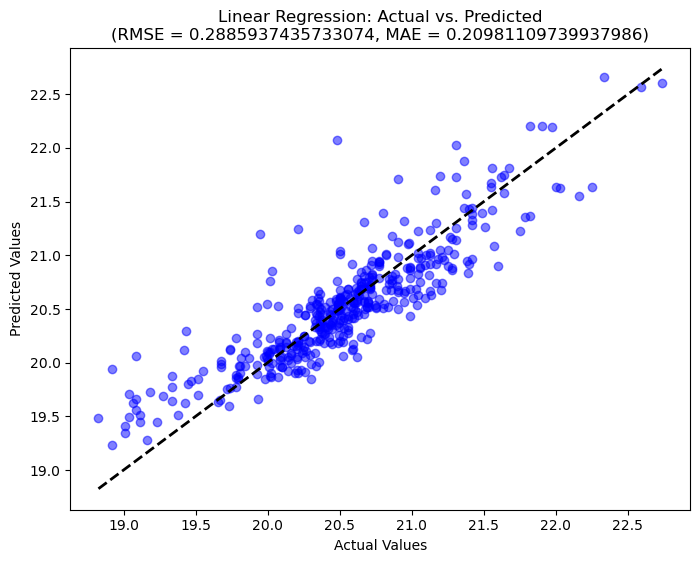

/tmp/ipykernel_1546/1158324208.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model_name, 'RMSE': rmse, 'MAE': mae}, ignore_index=True)


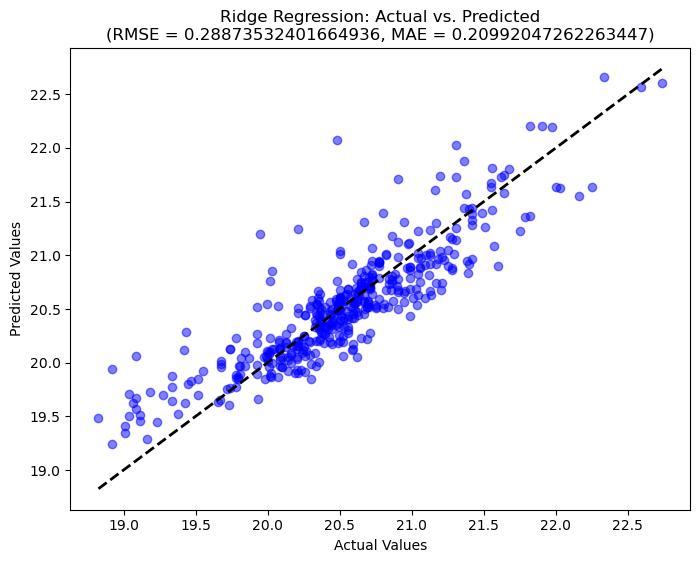

/tmp/ipykernel_1546/1158324208.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model_name, 'RMSE': rmse, 'MAE': mae}, ignore_index=True)


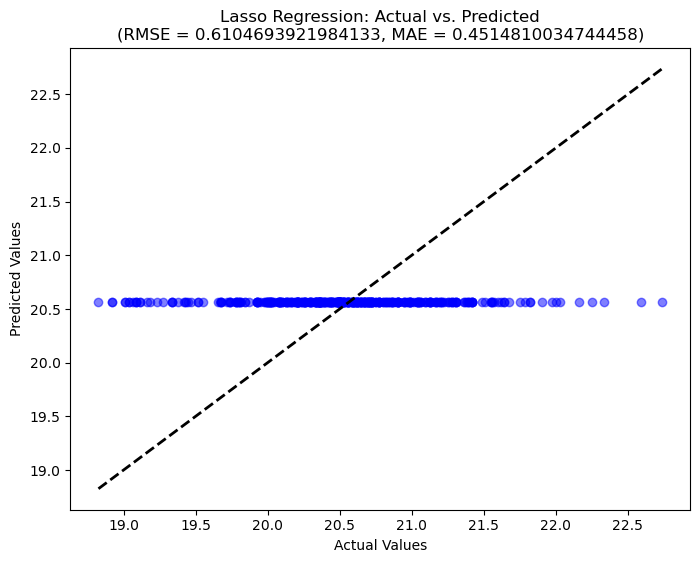

/tmp/ipykernel_1546/1158324208.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model_name, 'RMSE': rmse, 'MAE': mae}, ignore_index=True)


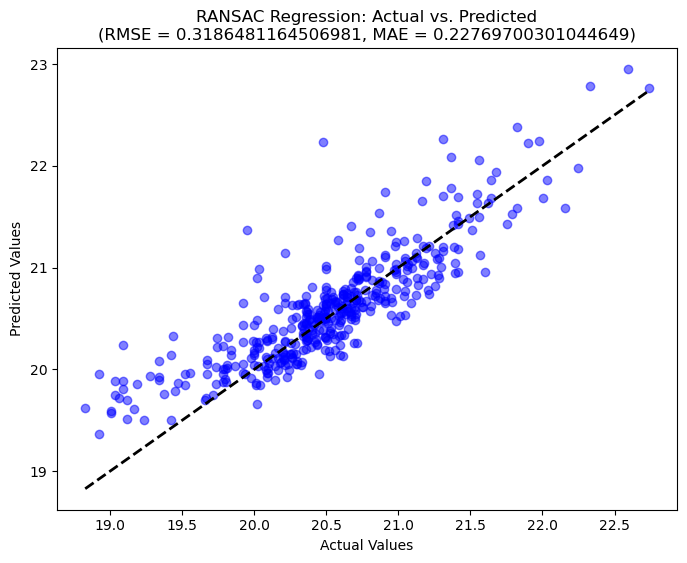

/tmp/ipykernel_1546/1158324208.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model_name, 'RMSE': rmse, 'MAE': mae}, ignore_index=True)


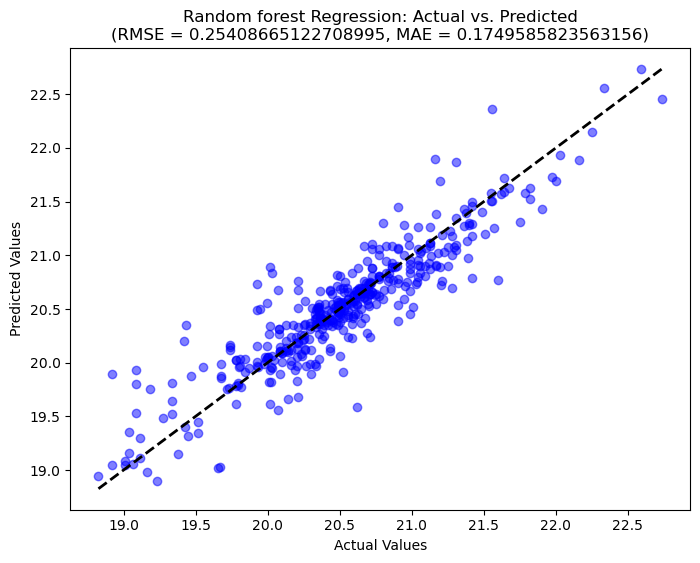

In [12]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    ('RANSAC Regression', RANSACRegressor()),
    ('Random forest Regression', RandomForestRegressor())
]

results_df = pd.DataFrame(columns=['Model', 'RMSE', 'MAE'])

for model_name, model in models:
    pipeline = Pipeline([
        ('Preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    results_df = results_df.append({'Model': model_name, 'RMSE': rmse, 'MAE': mae}, ignore_index=True)
    
    # Visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, c='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name}: Actual vs. Predicted\n(RMSE = {rmse}, MAE = {mae})")
    plt.show()

In [13]:
results_df

,Model,RMSE,MAE
0,Linear Regression,0.288594,0.209811
1,Ridge Regression,0.288735,0.209920
2,Lasso Regression,0.610469,0.451481
3,RANSAC Regression,0.318648,0.227697
4,Random forest Regression,0.254087,0.174959


## Parameter Tuning

In [14]:
pipeline = Pipeline([
    ('Preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['kamar_tidur', 'kamar_mandi',
                                                   'luas_bangunan',
                                                   'luas_lahan',
                                                   'keamanan24jam', 'taman',
                                                   'balcony', 'AC']),
                                                 ('cat',
                                                  Pipeline(steps=[('encode',
                                                                   OneHotEncoder())]),
                                                  ['lokasi'])])),
                ('model', RandomForestRegressor())])

In [15]:
# periksa setiap parameter yang terlibat dalam pembentukan model
pipeline.get_params()

{'memory': None,
 'steps': [('Preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('scaler', StandardScaler())]),
                                    ['kamar_tidur', 'kamar_mandi', 'luas_bangunan',
                                     'luas_lahan', 'keamanan24jam', 'taman',
                                     'balcony', 'AC']),
                                   ('cat',
                                    Pipeline(steps=[('encode', OneHotEncoder())]),
                                    ['lokasi'])])),
  ('model', RandomForestRegressor())],
 'verbose': False,
 'Preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['kamar_tidur', 'kamar_mandi', 'luas_bangunan',
                                   'luas_lahan', 'keamanan24jam', 'taman',
                                   'balcony', 'AC']),
                         

In [19]:
params = {'model__n_estimators':[25, 50, 100, 150],
          'model__max_depth':[None, 3, 6, 9],
          'model__min_samples_split':[1, 2, 4, 8],
          'model__max_leaf_nodes': [None, 3, 6, 9]
    }

model = GridSearchCV(pipeline, 
                     param_grid=params, 
                     cv=3, 
                     n_jobs=-1, 
                     verbose=1
                    )

model.fit(X_train, y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


/home/anggapark/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
192 fits failed out of a total of 768.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anggapark/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/anggapark/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/anggapark/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/ensemble/_for

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['kamar_tidur',
                                                                          'kamar_mandi',
                                                                          'luas_bangunan',
                                                                          'luas_lahan',
                                                                          'keamanan24jam',
                                                                          'taman',
                                                                          'balcony',
                                                                          'AC']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encode',
                                                                                          OneHotEncoder())]),
                                                                         ['lokasi'])])),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 3, 6, 9],
                         'model__max_leaf_nodes': [None, 3, 6, 9],
                         'model__min_samples_split': [1, 2, 4, 8],
                         'model__n_estimators': [25, 50, 100, 150]},
             verbose=1)

In [20]:
pd.DataFrame(model.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__max_leaf_nodes,param_model__min_samples_split,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
10,0.367149,0.007760,0.019010,0.002582,None,None,4,100,"{'model__max_depth': None, 'model__max_leaf_no...",0.822735,0.845207,0.805642,0.824528,0.016202,1
12,0.082189,0.005008,0.006955,0.001227,None,None,8,25,"{'model__max_depth': None, 'model__max_leaf_no...",0.818665,0.846376,0.806995,0.824012,0.016516,2
14,0.304664,0.006011,0.013979,0.000413,None,None,8,100,"{'model__max_depth': None, 'model__max_leaf_no...",0.822494,0.844830,0.804605,0.823976,0.016455,3
207,0.406771,0.008875,0.020122,0.001854,9,None,8,150,"{'model__max_depth': 9, 'model__max_leaf_nodes...",0.820852,0.842861,0.805275,0.822996,0.015419,4
202,0.306950,0.015492,0.017440,0.001293,9,None,4,100,"{'model__max_depth': 9, 'model__max_leaf_nodes...",0.823242,0.841564,0.803130,0.822645,0.015696,5


In [21]:
model.best_params_

{'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_split': 4,
 'model__n_estimators': 100}

In [22]:
pipeline = Pipeline([
    ('Preprocessor', preprocessor),
    ('model', RandomForestRegressor(max_depth=None,
                                    max_leaf_nodes=None,
                                    min_samples_split=4,
                                    n_estimators=100))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [23]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

rmse, mae

(0.25344016061923225, 0.1741394652992432)

## Save Model

In [24]:
import joblib

encoder = pipeline.named_steps['Preprocessor'].named_transformers_['cat'].named_steps['encode']
joblib.dump(encoder, 'encoder.joblib')

['encoder.joblib']

In [25]:
model_filename = 'model.joblib'
joblib.dump(pipeline, model_filename)

['model.joblib']